## Prueba con medidas estadísticas de kt, y solo std de long

In [1]:
# Librerías

# Tratamiento de datos
import pandas as pd
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
from numpy import reshape
import itertools
import shutil
import os, re
import time
import xgboost as xgb
from os import path
import pickle
from sklearn.manifold import TSNE
from keras.datasets import mnist
from pvlib.iotools import read_tmy3
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from pathlib import Path
from dateutil.parser import parse
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import cohen_kappa_score

In [2]:
# Importamos los datos de interés

# Experimento 7: kt estadìsticos (sin datos del modelo)

name = ['kt_modificado_mean','kt_modificado_std','kt_modificado_max','kurt_kt_modificado','skew_kt_modificado',\
        'long_std', 'rmse', 'sigma_mean']

name_c = ['kt_modificado_mean','kt_modificado_std','kt_modificado_max','kurt_kt_modificado','skew_kt_modificado',\
        'long_std', 'rmse', 'sigma_mean','clasificacion']


# x train, y train
dias_train = (pd.read_csv('dias_train_tabla_33_.csv'))
dias_train = dias_train.drop('fecha.1', axis=1)
dias_train = dias_train[name_c]
dias_train = dias_train.replace([np.inf, -np.inf], np.nan)
dias_train = dias_train.dropna()
x_train = dias_train[name]
y_train = pd.DataFrame(dias_train['clasificacion'])
y_train = np.ravel(y_train)

# x test, y test
dias_test = (pd.read_csv('dias_test_filtrado_tabla_33_.csv'))
dias_test = dias_test.drop('fecha.1', axis=1)
dias_test = dias_test[name_c]
dias_test = dias_test.replace([np.inf, -np.inf], np.nan)
dias_test = dias_test.dropna()
x_test = dias_test[name]
y_test = pd.DataFrame(dias_test['clasificacion'])

# x val, y val
dias_val = (pd.read_csv('dias_val_filtrado_tabla_33_.csv'))
dias_val = dias_val.drop('fecha.1', axis=1)
dias_val = dias_val[name_c]
dias_val = dias_val.replace([np.inf, -np.inf], np.nan)
dias_val = dias_val.dropna()
x_val = dias_val[name]
y_val = pd.DataFrame(dias_val['clasificacion'])

In [3]:
# x test extra mixed
x_test_mixed_ = pd.read_csv('dias_test_filtrado_mixed_33min_2.csv')
x_test_mixed = x_test_mixed_[name]
x_test_mixed = x_test_mixed.dropna()
x_test_mixed_cc = pd.read_csv('dias_test_filtrado_mixed_33min_2.csv')
y_test_mixed = pd.DataFrame(x_test_mixed_.clasificacion)

In [4]:
# Normalizamos los datos para evitar data leakage

# calculamos la media y el desvio de los datos de entrenamiento
mu = np.mean(x_train)
sigma = np.std(x_train)

# normalizamos los datos de entrenamiento, validacion y test usando media y desvio estimado
x_train = (x_train - mu) / sigma
x_val = (x_val - mu) / sigma
x_test = (x_test - mu) / sigma
#x_test_mixed = (x_test_mixed - mu) / sigma

In [5]:
mu

kt_modificado_mean      0.670167
kt_modificado_std       0.115648
kt_modificado_max       0.842688
kurt_kt_modificado      0.248645
skew_kt_modificado     -0.294164
long_std              457.116486
rmse                  167.488495
sigma_mean              0.071786
dtype: float64

In [6]:
x_val

,kt_modificado_mean,kt_modificado_std,kt_modificado_max,kurt_kt_modificado,skew_kt_modificado,long_std,rmse,sigma_mean
0,-0.725227,0.473904,-0.083259,-0.430620,0.536166,-0.070290,-0.233488,1.511821
1,0.092753,0.005579,0.493335,-0.254188,0.682196,-0.060517,0.027967,0.806516
2,-3.231047,-0.787022,-3.558979,-0.471410,0.906111,-0.071710,4.562387,-0.969705
3,-3.085778,-1.069467,-3.606695,0.353238,1.116369,-0.072641,2.274890,-0.992566
4,-1.970095,-0.917252,-2.518258,-0.552479,0.590645,-0.072648,1.066721,-0.961031
...,...,...,...,...,...,...,...,...
158,-1.804281,-0.928901,-2.243384,-0.042810,1.374346,-0.072502,1.548313,-0.973135
159,0.403959,0.454600,0.706530,-0.194305,-0.254418,-0.071419,-0.492656,-0.094201
160,-3.408121,-1.112962,-4.014823,-0.413243,0.138448,-0.072674,3.813204,-0.983771
161,-1.085211,1.623858,1.281712,-0.231179,1.271708,-0.053291,1.921613,1.995936


               Train Counts  Val Counts  Test Counts
altocumulus             513          25           20
cirrus                  571          31           45
clearsky                802          70           59
cumulonimbus            361          10           15
cumulus                 434          13           11
stratocumulus           350          12           11
               Train Counts %  Val Counts %  Test Counts %
altocumulus         16.925107     15.527950      12.422360
cirrus              18.838667     19.254658      27.950311
clearsky            26.459914     43.478261      36.645963
cumulonimbus        11.910261      6.211180       9.316770
cumulus             14.318707      8.074534       6.832298
stratocumulus       11.547344      7.453416       6.832298


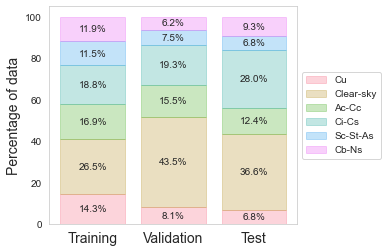

In [7]:
import matplotlib.font_manager as fm

nombres_nubes = ['cumulus', 'clearsky', 'altocumulus', 'cirrus', 'stratocumulus', 'cumulonimbus']
names_nubes = ['Cu', 'Clear-sky', 'Ac-Cc', 'Ci-Cs', 'Sc-St-As', 'Cb-Ns']

# Contar el número de instancias de cada tipo de nube en cada set de datos
train_counts = dias_train['clasificacion'].value_counts()
val_counts = dias_val['clasificacion'].value_counts()
test_counts = dias_test['clasificacion'].value_counts()

data = {'Train Counts': train_counts, 'Val Counts': val_counts, 'Test Counts': test_counts}
data2 = pd.DataFrame(data)
print(data2)

# Calcular el porcentaje de cada tipo de nube en cada conjunto de datos
train_percentages = train_counts / len(dias_train) * 100
val_percentages = val_counts / len(dias_val) * 100
test_percentages = test_counts / len(dias_test) * 100

dataa = {'Train Counts %': train_percentages, 'Val Counts %': val_percentages, 'Test Counts %': test_percentages}
data3 = pd.DataFrame(dataa)
print(data3)

# Establecer la fuente a Arial
font = fm.FontProperties(family='Arial')

# Crear el gráfico de barras apiladas
sns.set_style('whitegrid')
sns.set_palette('husl')
labels = ['Training', 'Validation', 'Test']
x = range(len(labels))
fig, ax = plt.subplots()
bottom = [0, 0, 0]

for i, nube in enumerate(nombres_nubes):
    percentages = [train_percentages[nube], val_percentages[nube], test_percentages[nube]]
    color = sns.color_palette()[i]
    ax.bar(x, percentages, bottom=bottom, label=names_nubes[i], alpha=0.3, linewidth=1, edgecolor=color, color=color)
    
    # Agregar los porcentajes en el gráfico
    for j in range(3):
        percentage = percentages[j]
        if percentage > 0:  # Solo agregar el texto si el porcentaje es mayor a 0
            ax.text(j, bottom[j] + percentage / 2, f'{percentage:.1f}%', ha='center', va='center', fontproperties=font)
    
    bottom = [bottom[j] + percentages[j] for j in range(3)]

# Etiquetas y leyenda
ax.set_xticks(x)
ax.set_xticklabels(labels, fontproperties=font)
ax.tick_params(axis='x', labelsize=14)  # Ajustar el tamaño de la fuente del eje x aquí
ax.set_ylabel('Percentage of data', fontsize=14, fontproperties=font)
plt.subplots_adjust(right=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop=font)
ax.grid(False)

# Mostrar el gráfico
plt.show()

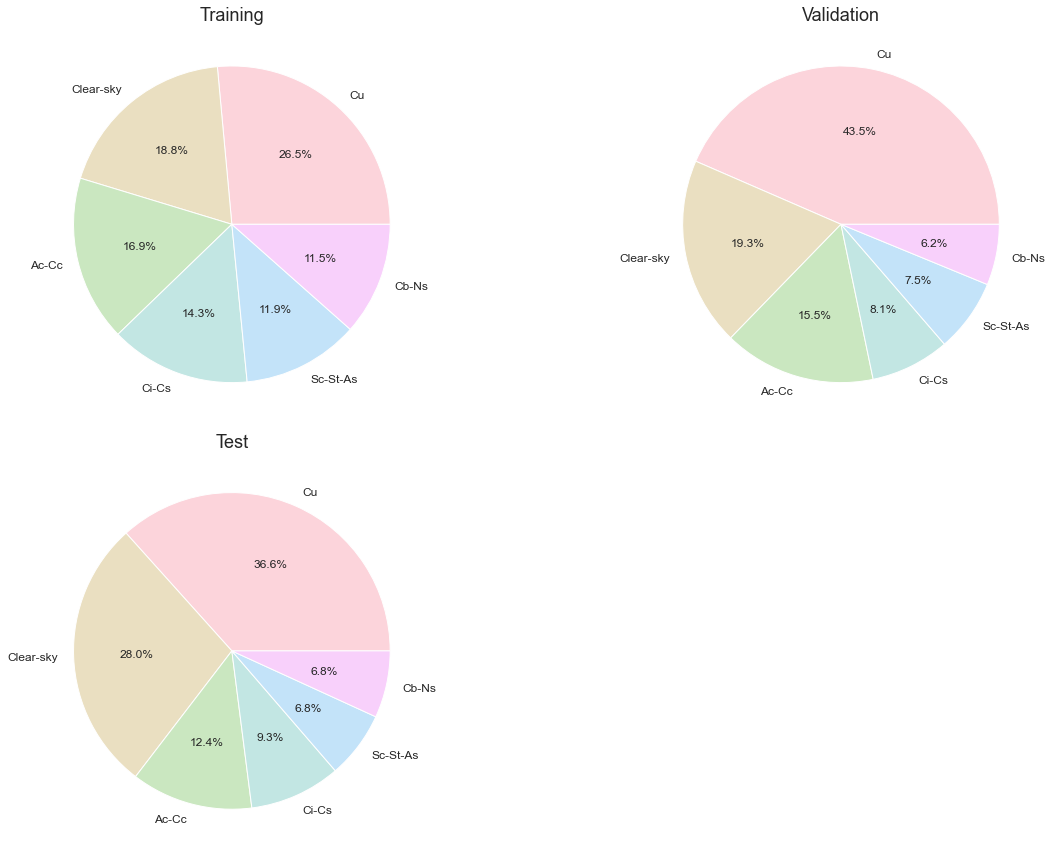

In [8]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Establecer la fuente a Arial
font = fm.FontProperties(family='Arial')

# Crear el gráfico de torta
fig, axs = plt.subplots(2, 2, figsize=(18, 12))  # Crear una figura con 4 subgráficos
datasets = [train_percentages, val_percentages, test_percentages]  # Lista de los conjuntos de datos
labels = ['Training', 'Validation', 'Test']  # Etiquetas para los gráficos de torta
colors = sns.color_palette()  # Obtener la paleta de colores de seaborn

# Ajustar la transparencia de los colores
colors = [(r, g, b, 0.3) for r, g, b in colors]

# Crear los gráficos de torta
for i, ax in enumerate(axs.flatten()[:3]):
    ax.pie(datasets[i], labels=names_nubes, autopct='%1.1f%%', colors=colors)
    
    # Aumentar el tamaño de la fuente de los porcentajes y de las clases
    ax.set_title(labels[i], fontproperties=font, fontsize=18)  # Aumentar el tamaño de la fuente del título
    for text in ax.texts:
        text.set_fontsize(12)  # Aumentar el tamaño de la fuente de los porcentajes y de las clases

# Eliminar el subgráfico vacío
fig.delaxes(axs.flatten()[3])

# Mostrar el gráfico
plt.tight_layout()
plt.show()


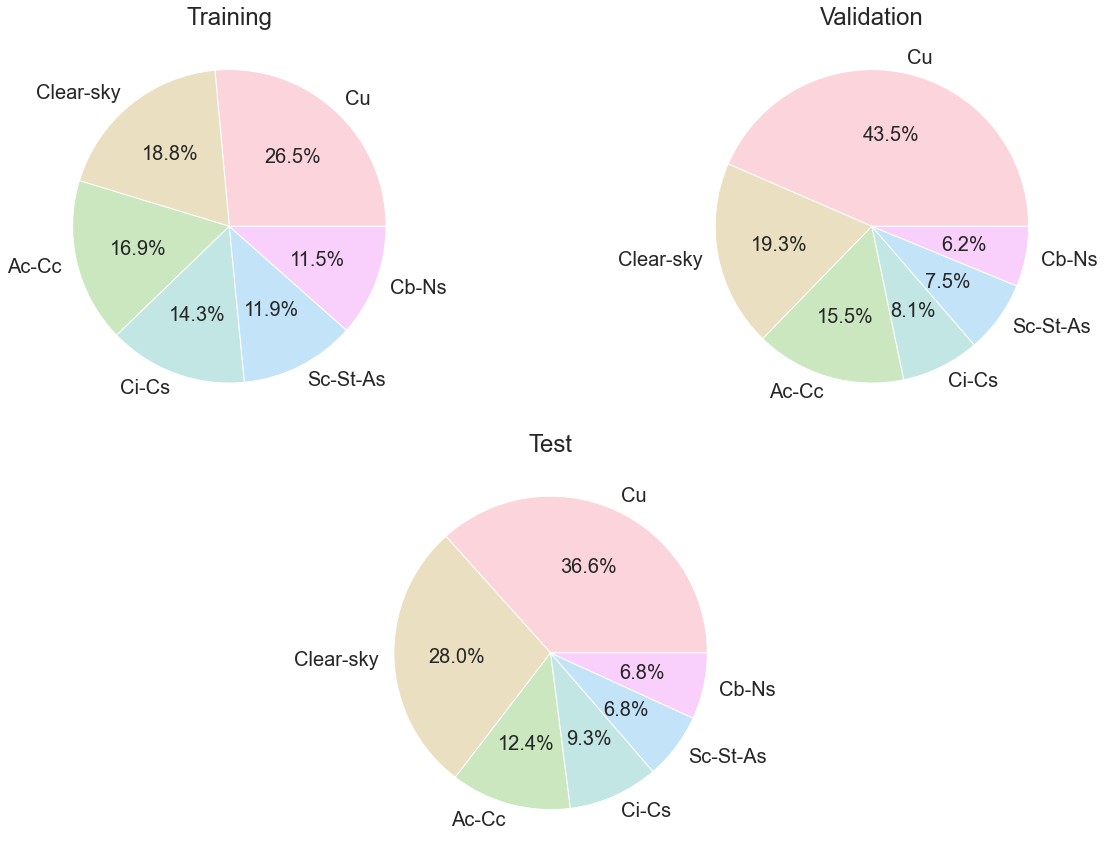

In [14]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Establecer la fuente a Arial
font = fm.FontProperties(family='Arial')

# Crear los gráficos de torta superiores
fig, axs = plt.subplots(2, 2, figsize=(18, 12))  # Crear una figura con 4 subgráficos
datasets = [train_percentages, val_percentages, test_percentages]  # Lista de los conjuntos de datos
labels = ['Training', 'Validation', 'Test']  # Etiquetas para los gráficos de torta
colors = sns.color_palette()  # Obtener la paleta de colores de seaborn

# Ajustar la transparencia de los colores
colors = [(r, g, b, 0.3) for r, g, b in colors]

# Crear los gráficos de torta superiores
for i, ax in enumerate([axs[0, 0], axs[0, 1]]):
    ax.pie(datasets[i], labels=names_nubes, autopct='%1.1f%%', colors=colors)
    
    # Aumentar el tamaño de la fuente de los porcentajes y de las clases
    ax.set_title(labels[i], fontproperties=font, fontsize=24)  # Aumentar el tamaño de la fuente del título
    for text in ax.texts:
        text.set_fontsize(20)  # Aumentar el tamaño de la fuente de los porcentajes y de las clases

# Eliminar los subgráficos de las esquinas inferiores
fig.delaxes(axs[1, 0])
fig.delaxes(axs[1, 1])

# Crear el gráfico de torta inferior en el medio
ax = fig.add_subplot(2, 2, (3, 4))
ax.pie(datasets[2], labels=names_nubes, autopct='%1.1f%%', colors=colors)
ax.set_title(labels[2], fontproperties=font, fontsize=24)
for text in ax.texts:
    text.set_fontsize(20)

# Mostrar los gráficos
plt.tight_layout()
plt.show()


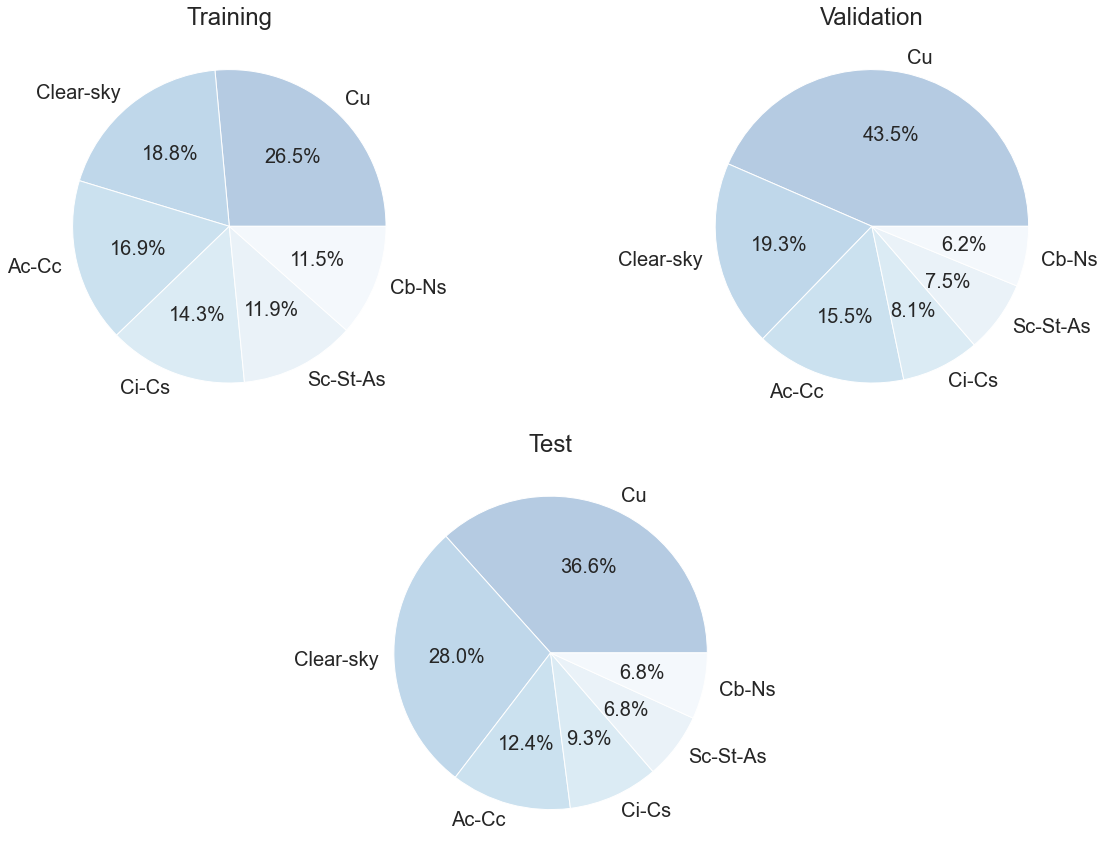

In [18]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Establecer la fuente a Arial
font = fm.FontProperties(family='Arial')

# Crear los gráficos de torta superiores
fig, axs = plt.subplots(2, 2, figsize=(18, 12))  # Crear una figura con 4 subgráficos
datasets = [train_percentages, val_percentages, test_percentages]  # Lista de los conjuntos de datos
labels = ['Training', 'Validation', 'Test']  # Etiquetas para los gráficos de torta
colors = sns.color_palette('Blues_r')  # Obtener la paleta de colores de seaborn

# Ajustar la transparencia de los colores
colors = [(r, g, b, 0.3) for r, g, b in colors]

# Crear los gráficos de torta superiores
for i, ax in enumerate([axs[0, 0], axs[0, 1]]):
    ax.pie(datasets[i], labels=names_nubes, autopct='%1.1f%%', colors=colors)
    
    # Aumentar el tamaño de la fuente de los porcentajes y de las clases
    ax.set_title(labels[i], fontproperties=font, fontsize=24)  # Aumentar el tamaño de la fuente del título
    for text in ax.texts:
        text.set_fontsize(20)  # Aumentar el tamaño de la fuente de los porcentajes y de las clases

# Eliminar los subgráficos de las esquinas inferiores
fig.delaxes(axs[1, 0])
fig.delaxes(axs[1, 1])

# Crear el gráfico de torta inferior en el medio
ax = fig.add_subplot(2, 2, (3, 4))
ax.pie(datasets[2], labels=names_nubes, autopct='%1.1f%%', colors=colors)
ax.set_title(labels[2], fontproperties=font, fontsize=24)
for text in ax.texts:
    text.set_fontsize(20)

# Mostrar los gráficos
plt.tight_layout()
plt.show()

## Modelos

### Regresión logística OVR

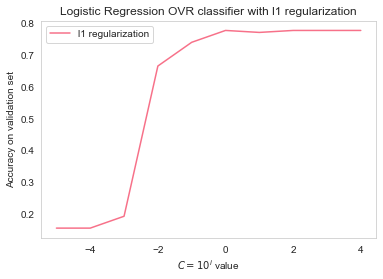

Logistic regression OVR classifier with l1 regularization
-----------------------
Best C: 1
Accuracy on validation set: 0.7763975155279503
Índice Kappa: 0.6944166183371119
-----------------------
Confusion matrix using Pandas and Seaborn:


C:\Users\LABORA~1\AppData\Local\Temp/ipykernel_13264/2890469270.py:52: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]


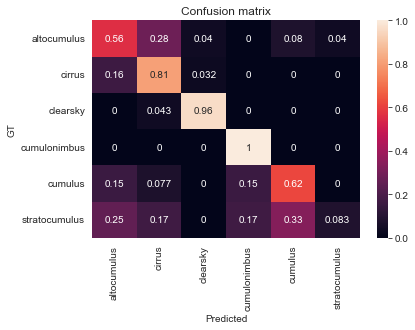

Precision, Recall and f-1 Scores for Logistic Regression:
               precision    recall  f1-score   support

  altocumulus       0.58      0.56      0.57        25
       cirrus       0.66      0.81      0.72        31
     clearsky       0.97      0.96      0.96        70
 cumulonimbus       0.71      1.00      0.83        10
      cumulus       0.57      0.62      0.59        13
stratocumulus       0.50      0.08      0.14        12

     accuracy                           0.78       161
    macro avg       0.67      0.67      0.64       161
 weighted avg       0.77      0.78      0.76       161



In [19]:
# valores de C que vamos a probar
C_values = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]

# elegimos el regularizador (comentar la linea que no queremos)
#regularizer = 'l2'
regularizer = 'l1'

# inicializamos un vector donde guardaremos los valores de accuracy
reg_log_reg_accuracy_val = np.zeros(len(C_values))
# inicializamos también una lista para guardar cada modelo que entrenemos
reg_log_reg_models = []

# probamos cada valor de C
for i in range(len(C_values)):
  # inicializamos el modelo
  model1 = LogisticRegression(penalty=regularizer, fit_intercept=True, C=10**(C_values[i]), solver='liblinear', multi_class='ovr', max_iter=1000, random_state=123)
  reg_log_reg_models.append(model1)
  # lo entrenamos sobre los datos de entrenamiento
  model1.fit(x_train, y_train)
  # lo corremos sobre los datos de validación
  y_hat_val = model1.predict(x_val)
  # y evaluamos su accuracy comparando estas etiquetas con el ground truth
  reg_log_reg_accuracy_val[i] = accuracy_score(y_val, y_hat_val)

# identificamos el mejor valor de C a partir del accuracy más alto
C_idx = np.argmax(reg_log_reg_accuracy_val)
# lo reservamos
regularized_logistic_regression_model = reg_log_reg_models[C_idx]

# mostramos un gráfico ilustrando la evolución del accuracy para cada C
plt.plot(C_values, reg_log_reg_accuracy_val)
#plt.plot(C_values, np.ones(len(C_values)) * basic_log_reg_accuracy_val)
plt.xlabel('$C=10^i$ value')
plt.grid()
plt.ylabel('Accuracy on validation set')
plt.title('Logistic Regression OVR classifier with {} regularization'.format(regularizer))
plt.legend(['{} regularization'.format(regularizer), 'Unregularized'])
plt.show(True)

# imprimimos los resultados por pantalla
print('Logistic regression OVR classifier with {} regularization'.format(regularizer))
print('-----------------------')
print('Best C: {}'.format(10**C_values[C_idx]))
print('Accuracy on validation set: {}'.format(reg_log_reg_accuracy_val[C_idx]))
print('Índice Kappa: {}'.format(cohen_kappa_score(y_val, y_hat_val)))
print('-----------------------')

# obtenemos la matriz usando pandas y seaborn
print('Confusion matrix using Pandas and Seaborn:')
df = pd.DataFrame({'GT': np.ravel(y_val), 'Predicted': y_hat_val}, columns=['GT','Predicted'])
conf_mat = pd.crosstab(df['GT'], df['Predicted'], rownames=['GT'], colnames=['Predicted'], margins = False)
cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
ax = plt.axes()
sns.heatmap(cmn, ax=ax, annot=True)
ax.set_title('Confusion matrix')
plt.show()

# obtenemos el reporte de clasificación
print('Precision, Recall and f-1 Scores for Logistic Regression:')
print(classification_report(y_val, y_hat_val))

model1_precision = precision_score(y_val, y_hat_val, average=None)
model1_recall = recall_score(y_val, y_hat_val, average=None)
model1_f1 = f1_score(y_val, y_hat_val, average=None)
model1_acc = reg_log_reg_accuracy_val[C_idx]

In [20]:
# guardamos el mejor modelo como un archivo pickle
model_filename = path.join('nubes_model1_exp8_33min.pkl')

print('\nSaving {}'.format(model_filename))
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model1}, f)


Saving nubes_model1_exp8_33min.pkl


## Regresión logística multinomial (Softmax regression)

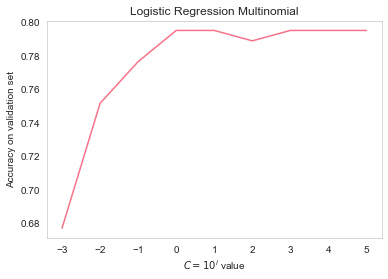

Logistic regression multinomial
-----------------------
Best C: 1
Accuracy on validation set: 0.7950310559006211
Índice Kappa: 0.7204566978848785
-----------------------
Confusion matrix using Pandas and Seaborn:


C:\Users\LABORA~1\AppData\Local\Temp/ipykernel_13264/2353186134.py:45: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]


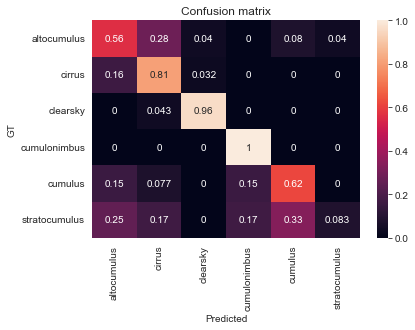

Precision, Recall and f-1 Scores for Logistic Regression Multinomial:
               precision    recall  f1-score   support

  altocumulus       0.64      0.64      0.64        25
       cirrus       0.71      0.81      0.76        31
     clearsky       0.97      0.96      0.96        70
 cumulonimbus       0.83      1.00      0.91        10
      cumulus       0.60      0.69      0.64        13
stratocumulus       0.20      0.08      0.12        12

     accuracy                           0.80       161
    macro avg       0.66      0.70      0.67       161
 weighted avg       0.77      0.80      0.78       161



In [21]:
# valores de C que vamos a probar
C_values = [-3, -2, -1, 0, 1, 2, 3, 4, 5]

# inicializamos un vector donde guardaremos los valores de accuracy
linear_classifier_accuracy_val = np.zeros(len(C_values))

# arreglo para ir guardando los valores de accuracy
linear_classifier_models = []

# probamos cada valor de C
for i in range(len(C_values)):
  # inicializamos el modelo
  model2 = LogisticRegression(penalty='l2', fit_intercept=True, C=10**(C_values[i]), solver='newton-cg', multi_class='multinomial', max_iter=1000, random_state=123)
  linear_classifier_models.append(model2)
  # lo entrenamos sobre los datos de entrenamiento
  model2.fit(x_train, y_train)
  # lo corremos sobre los datos de validación
  y_hat_val = model2.predict(x_val)
  # y evaluamos su accuracy comparando estas etiquetas con el ground truth
  linear_classifier_accuracy_val[i] = accuracy_score(y_val, y_hat_val)

# identificamos el mejor valor de C a partir del accuracy más alto
C_idx = np.argmax(linear_classifier_accuracy_val)

# mostramos un gráfico ilustrando la evolución del accuracy para cada C
plt.plot(C_values, linear_classifier_accuracy_val)
#plt.plot(C_values, np.ones(len(C_values)) * basic_log_reg_accuracy_val)
plt.xlabel('$C=10^i$ value')
plt.grid()
plt.ylabel('Accuracy on validation set')
plt.title('Logistic Regression Multinomial')
plt.show()

# imprimimos los resultados por pantalla
print('Logistic regression multinomial')
print('-----------------------')
print('Best C: {}'.format(10**C_values[C_idx]))
print('Accuracy on validation set: {}'.format(linear_classifier_accuracy_val[C_idx]))
print('Índice Kappa: {}'.format(cohen_kappa_score(y_val, y_hat_val)))
print('-----------------------')

# obtenemos la matriz usando pandas y seaborn
print('Confusion matrix using Pandas and Seaborn:')
df = pd.DataFrame({'GT': np.ravel(y_val), 'Predicted': y_hat_val}, columns=['GT','Predicted'])
cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
ax = plt.axes()
sns.heatmap(cmn, ax=ax, annot=True)
ax.set_title('Confusion matrix')
plt.show()

# obtenemos el reporte de clasificación
print('Precision, Recall and f-1 Scores for Logistic Regression Multinomial:')
print(classification_report(y_val, y_hat_val))

model2_precision = precision_score(y_val, y_hat_val, average=None)
model2_recall = recall_score(y_val, y_hat_val, average=None)
model2_f1 = f1_score(y_val, y_hat_val, average=None)
model2_acc = linear_classifier_accuracy_val[C_idx] 

In [22]:
# guardamos el mejor modelo como un archivo pickle
model_filename = path.join('nubes_model2_exp8_33min.pkl')

print('\nSaving {}'.format(model_filename))
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model2}, f)


Saving nubes_model2_exp8_33min.pkl


## Random Forest

Confusion matrix using Pandas and Seaborn:


C:\Users\LABORA~1\AppData\Local\Temp/ipykernel_13264/3312412967.py:38: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]


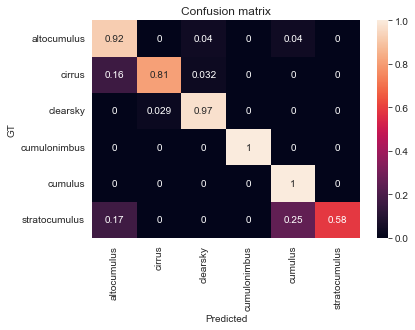

Precision, Recall and f-1 Scores for Random Forest Classifier:
               precision    recall  f1-score   support

  altocumulus       0.77      0.92      0.84        25
       cirrus       0.93      0.81      0.86        31
     clearsky       0.97      0.97      0.97        70
 cumulonimbus       1.00      1.00      1.00        10
      cumulus       0.76      1.00      0.87        13
stratocumulus       1.00      0.58      0.74        12

     accuracy                           0.91       161
    macro avg       0.90      0.88      0.88       161
 weighted avg       0.92      0.91      0.91       161

Random Forest
-----------------------
Accuracy on validation set: 0.906832298136646
Índice Kappa: 0.873088443953965
-----------------------


In [23]:
rf_models = []

param_grid = {
    'n_estimators': [5, 10, 25, 50, 100, 200],  # number of trees
    'max_depth':  [3, 5, 7, 9, 11, None]  # depth of the trees
}

params_grid = [values for values in itertools.product(*param_grid.values())]

resultados = pd.DataFrame()

for params in params_grid:
    
    model3 = RandomForestClassifier(random_state = 123,
                          n_estimators = params[0],
                          max_depth = params[1]).fit(x_train, y_train)
    
    rf_models.append(model3)                   
    
    y_hat_val = model3.predict(x_val)

    corrida = { 'estimators' : params[0],
                'max_depth' : params[1],
                'accuracy' : accuracy_score(y_val, y_hat_val)}
    
    resultados = pd.concat([resultados, pd.DataFrame(corrida, index = [0])], axis = 0, ignore_index=True)

# identificamos el mejor valor del accuracy más alto
param = np.argmax(resultados.accuracy)
model3 = rf_models[param]
model3.fit(x_train, y_train)
y_hat_val = model3.predict(x_val)

# obtenemos la matriz usando pandas y seaborn
print('Confusion matrix using Pandas and Seaborn:')
df = pd.DataFrame({'GT': np.ravel(y_val), 'Predicted': y_hat_val}, columns=['GT','Predicted'])
conf_mat = pd.crosstab(df['GT'], df['Predicted'], rownames=['GT'], colnames=['Predicted'], margins = False)
cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
ax = plt.axes()
sns.heatmap(cmn, ax=ax, annot=True)
ax.set_title('Confusion matrix')
plt.show()

# obtenemos un reporte
print('Precision, Recall and f-1 Scores for Random Forest Classifier:')
print(classification_report((np.ravel(y_val)), y_hat_val))

# imprimimos los resultados por pantalla
print('Random Forest')
print('-----------------------')
print('Accuracy on validation set: {}'.format(accuracy_score((np.ravel(y_val)), y_hat_val)))
print('Índice Kappa: {}'.format(cohen_kappa_score((np.ravel(y_val)), y_hat_val)))
print('-----------------------') # 0.8326180257510729

model3_precision = precision_score((np.ravel(y_val)), y_hat_val, average=None)
model3_recall = recall_score((np.ravel(y_val)), y_hat_val, average=None)
model3_f1 = f1_score((np.ravel(y_val)), y_hat_val, average=None)
model3_acc = accuracy_score((np.ravel(y_val)), y_hat_val) 

In [24]:
# guardamos el mejor modelo como un archivo pickle
model_filename = path.join('nubes_model3_exp8_33min.pkl')

print('\nSaving {}'.format(model_filename))
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model3}, f)


Saving nubes_model3_exp8_33min.pkl


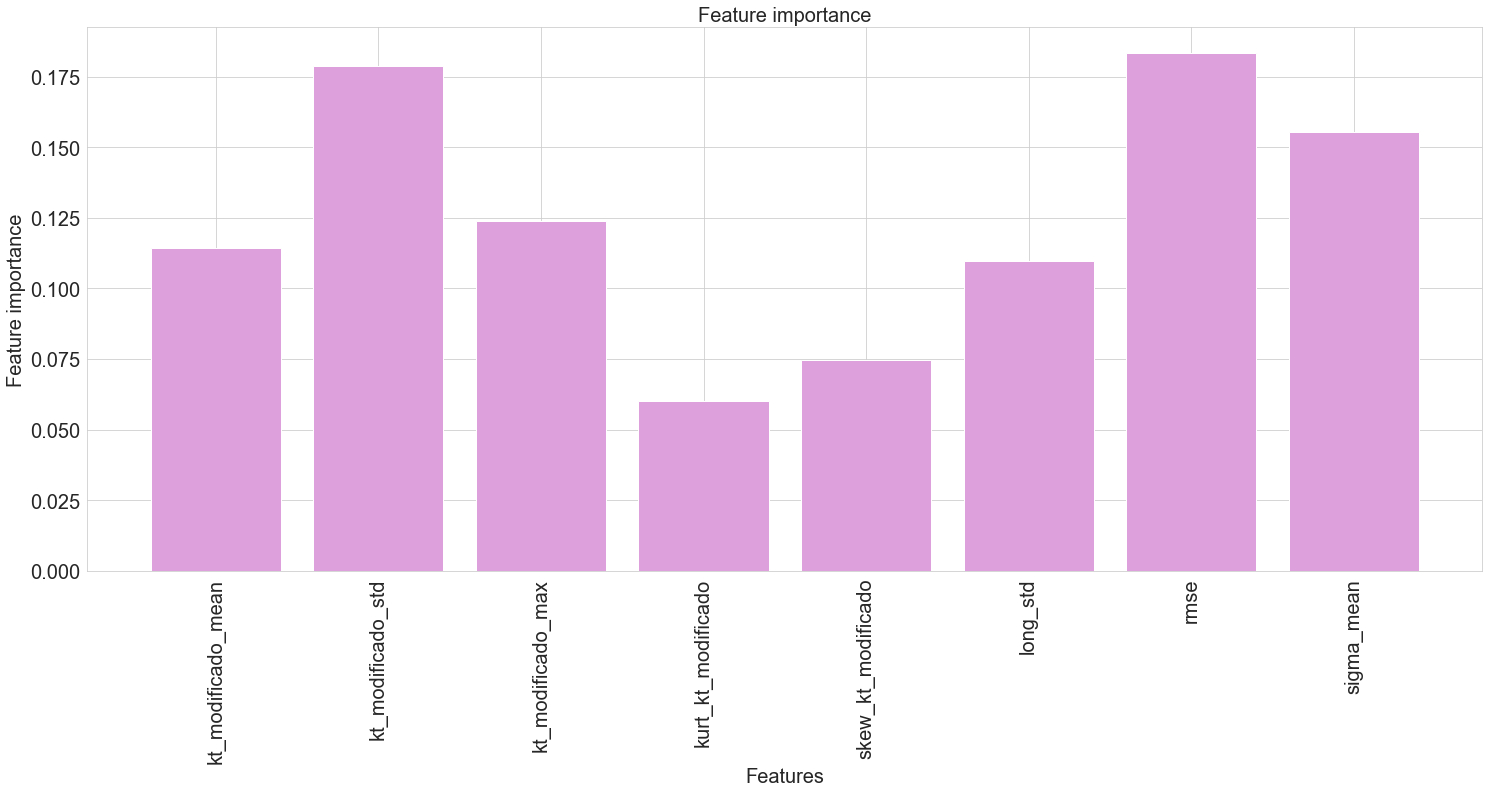

In [25]:
plt.figure(figsize=(25, 10))
plt.bar(np.arange(x_train.shape[1]), model3.feature_importances_,color='plum')
plt.xticks(ticks=np.arange(x_train.shape[1]),labels=x_train,rotation=90,size=20)
plt.yticks(size=20)
plt.title('Feature importance',size=20)
plt.xlabel('Features',size=20)
plt.ylabel('Feature importance',size=20)
plt.grid(True)
plt.show()

## XGBoost

In [26]:
# Importamos los datos de interés, ahora como df
# x train, y train
y_train = pd.DataFrame(y_train)

# create instance of label encoder
le = LabelEncoder()
# perform label encoding on 'team' column
y_train['le'] = le.fit_transform(np.ravel(y_train))
# clases
clases = le.classes_

Confusion matrix using Pandas and Seaborn:


C:\Users\LABORA~1\AppData\Local\Temp/ipykernel_13264/2433416195.py:41: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]


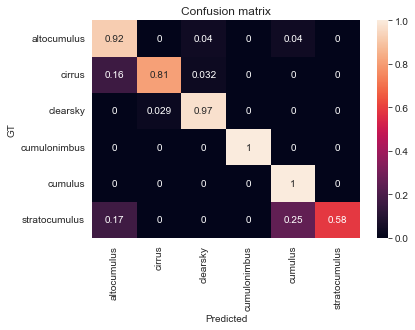

Precision, Recall and f-1 Scores for Random Forest Classifier:
               precision    recall  f1-score   support

  altocumulus       0.77      0.92      0.84        25
       cirrus       0.90      0.84      0.87        31
     clearsky       0.97      0.97      0.97        70
 cumulonimbus       1.00      1.00      1.00        10
      cumulus       0.85      0.85      0.85        13
stratocumulus       0.89      0.67      0.76        12

     accuracy                           0.91       161
    macro avg       0.89      0.87      0.88       161
 weighted avg       0.91      0.91      0.91       161

XGBoost
-----------------------
Accuracy on validation set: 0.906832298136646
Índice Kappa: 0.8728612792840221
-----------------------


In [27]:
# ajustamos los hiperparámetros
xgb_models = []

grid= {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5, 7],
    'learning_rate': [0.01, 0.03, 0.1]
}

params_grid = [values for values in itertools.product(*grid.values())]

resultados = pd.DataFrame()

for params in params_grid:
    
    model4 = xgb.XGBClassifier(random_state = 123,
                          n_estimators = params[0],
                          max_depth = params[1],
                          learning_rate = params[2],
                          objective="multi:softmax").fit(x_train, y_train['le'])
    xgb_models.append(model4)                   
    
    y_hat_val = model4.predict(x_val)

    corrida = {'estimators' : params[0],
               'max_depth' : params[1],
               'learning_rate' : params[2],
               'accuracy' : accuracy_score(le.fit_transform(np.ravel(y_val)), y_hat_val)}
    
    resultados = pd.concat([resultados, pd.DataFrame(corrida, index = [0])], axis = 0, ignore_index = True)
    
# identificamos el mejor valor del accuracy más alto
param = np.argmax(resultados.accuracy)
model4 = xgb_models[param]
model4.fit(x_train, y_train['le'])
y_hat_val = model4.predict(x_val)

# obtenemos la matriz usando pandas y seaborn
print('Confusion matrix using Pandas and Seaborn:')
df = pd.DataFrame({'GT': np.ravel(y_val), 'Predicted': le.inverse_transform(y_hat_val)}, columns=['GT','Predicted'])
cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
ax = plt.axes()
sns.heatmap(cmn, ax=ax, annot=True)
ax.set_title('Confusion matrix')
plt.show()

# obtenemos un reporte
print('Precision, Recall and f-1 Scores for Random Forest Classifier:')
print(classification_report(le.fit_transform(np.ravel(y_val)), y_hat_val,target_names=le.classes_))

# imprimimos los resultados por pantalla
print('XGBoost')
print('-----------------------')
print('Accuracy on validation set: {}'.format(accuracy_score(le.fit_transform(np.ravel(y_val)), y_hat_val)))
print('Índice Kappa: {}'.format(cohen_kappa_score(le.fit_transform(np.ravel(y_val)), y_hat_val)))
print('-----------------------')

model4_precision = precision_score(le.fit_transform(np.ravel(y_val)), y_hat_val, average=None)
model4_recall = recall_score(le.fit_transform(np.ravel(y_val)), y_hat_val, average=None)
model4_f1 = f1_score(le.fit_transform(np.ravel(y_val)), y_hat_val, average=None)
model4_acc = accuracy_score(le.fit_transform(np.ravel(y_val)), y_hat_val) 

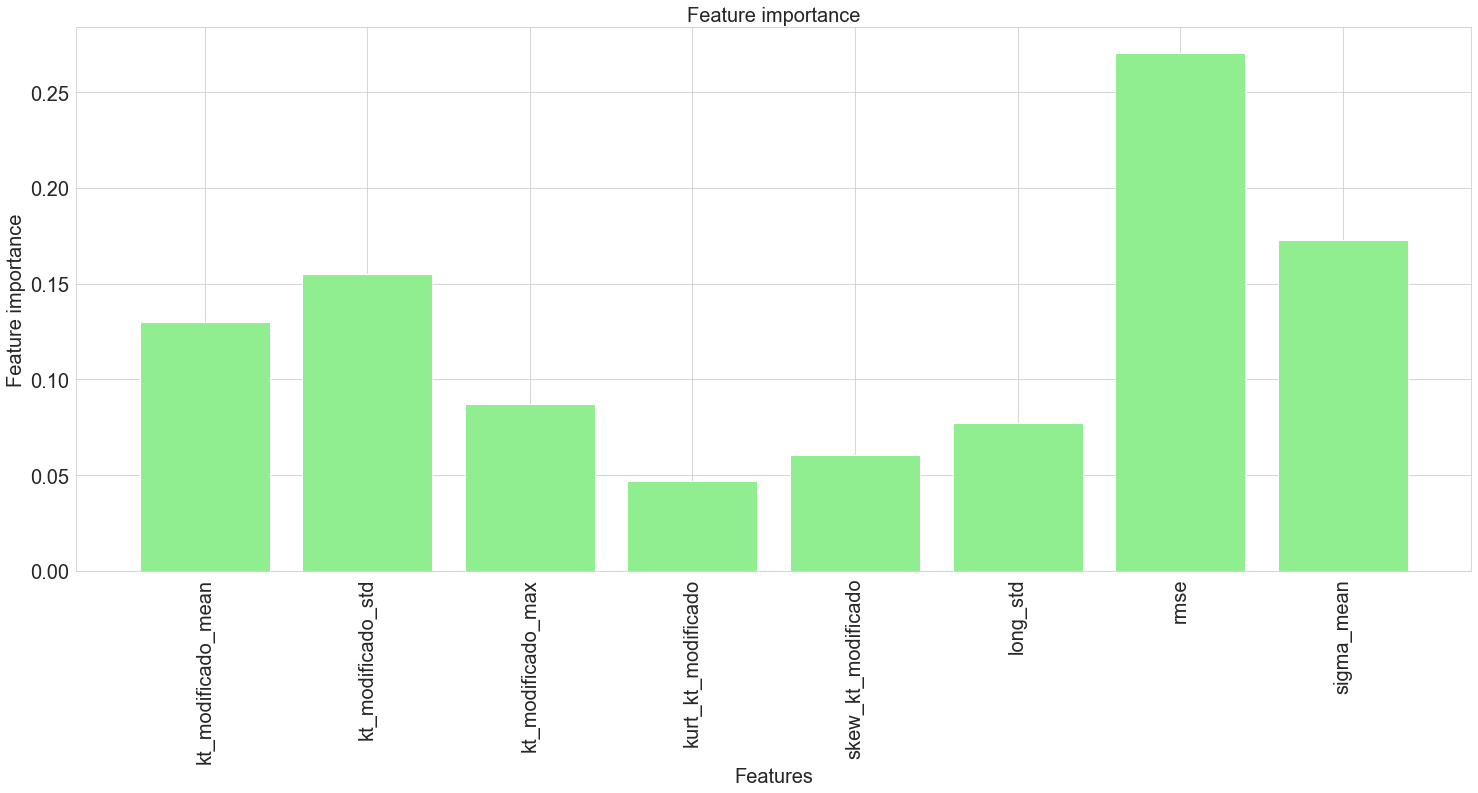

In [28]:
plt.figure(figsize=(25, 10))
plt.bar(np.arange(x_train.shape[1]),model4.feature_importances_,color='lightgreen')
plt.xticks(ticks=np.arange(x_train.shape[1]),labels=x_train,rotation=90,size='20')
plt.yticks(size='20')
plt.title('Feature importance',size='20')
plt.xlabel('Features',size='20')
plt.ylabel('Feature importance',size='20')
plt.grid(True)
plt.show()

In [29]:
# guardamos el mejor modelo como un archivo pickle
model_filename = path.join('nubes_model4_exp8_33min.pkl')

print('\nSaving {}'.format(model_filename))
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model4}, f)


Saving nubes_model4_exp8_33min.pkl


## Gráficos de comparación de desempeño en el conjunto de validación

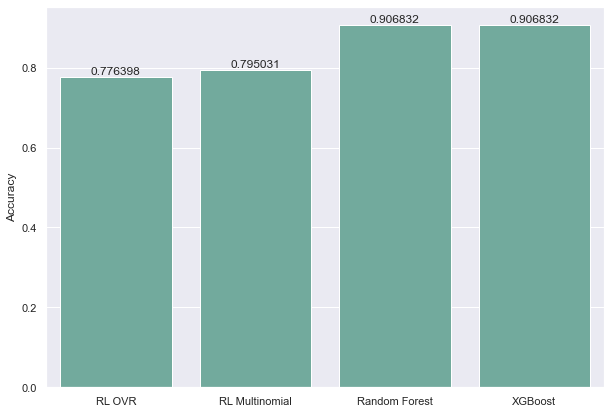

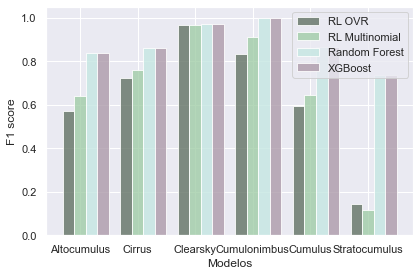

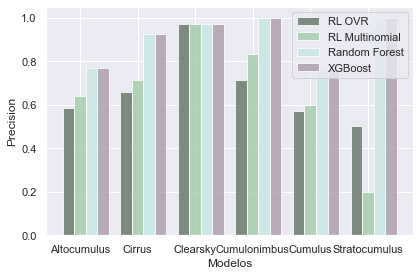

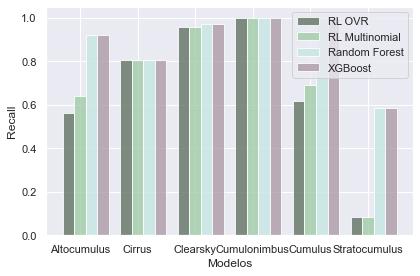

In [30]:
# Accuracy

datos = [model1_acc, model2_acc, model3_acc, model4_acc]
columnas = ['Accuracy']
filas = ['RL OVR','RL Multinomial','Random Forest','XGBoost']
df = pd.DataFrame(datos, columns=columnas, index=filas)

# set plot style: grey grid in the background:
sns.set(style="darkgrid")

# Set the figure size
plt.figure(figsize=(10, 7))

# plot a bar chart
ax = sns.barplot(x=df.index,y=df.Accuracy,data=df,estimator=sum,ci=None,color='#69b3a2')

for i in ax.containers:
    ax.bar_label(i)

##### 

# f1

dataf1 = [model1_f1, model2_f1, model3_f1, model4_f1]

n_groups = 6 

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

rects1 = plt.bar(index, dataf1[0], bar_width,alpha=opacity,color='#627264',label='RL OVR')
rects2 = plt.bar(index + bar_width, dataf1[1], bar_width,alpha=opacity,color='#A1CDA8',label='RL Multinomial')
rects3 = plt.bar(index + 2*bar_width, dataf1[2], bar_width,alpha=opacity,color='#C5E7E2',label='Random Forest')
rects4 = plt.bar(index + 3*bar_width, dataf1[2], bar_width,alpha=opacity,color='#AD9BAA',label='XGBoost')

plt.xlabel('Modelos')
plt.ylabel('F1 score')
plt.xticks(index + bar_width, ('Altocumulus','Cirrus','Clearsky','Cumulonimbus', 'Cumulus', 'Stratocumulus'))
plt.legend()

plt.tight_layout()
plt.show()

#####

# precision

datap = [model1_precision, model2_precision, model3_precision, model4_precision]

n_groups = 6 

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

rects1 = plt.bar(index, datap[0], bar_width,alpha=opacity,color='#627264',label='RL OVR')
rects2 = plt.bar(index + bar_width, datap[1], bar_width,alpha=opacity,color='#A1CDA8',label='RL Multinomial')
rects3 = plt.bar(index + 2*bar_width, datap[2], bar_width,alpha=opacity,color='#C5E7E2',label='Random Forest')
rects4 = plt.bar(index + 3*bar_width, datap[2], bar_width,alpha=opacity,color='#AD9BAA',label='XGBoost')

plt.xlabel('Modelos')
plt.ylabel('Precision')
plt.xticks(index + bar_width, ('Altocumulus','Cirrus','Clearsky','Cumulonimbus', 'Cumulus', 'Stratocumulus'))
plt.legend()

plt.tight_layout()
plt.show()

#####

# recall

datar = [model1_recall, model2_recall, model3_recall, model4_recall]

n_groups = 6 

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

rects1 = plt.bar(index, datar[0], bar_width,alpha=opacity,color='#627264',label='RL OVR')
rects2 = plt.bar(index + bar_width, datar[1], bar_width,alpha=opacity,color='#A1CDA8',label='RL Multinomial')
rects3 = plt.bar(index + 2*bar_width, datar[2], bar_width,alpha=opacity,color='#C5E7E2',label='Random Forest')
rects4 = plt.bar(index + 3*bar_width, datar[2], bar_width,alpha=opacity,color='#AD9BAA',label='XGBoost')

plt.xlabel('Modelos')
plt.ylabel('Recall')
plt.xticks(index + bar_width, ('Altocumulus','Cirrus','Clearsky','Cumulonimbus', 'Cumulus', 'Stratocumulus'))
plt.legend()

plt.tight_layout()
plt.show()

#####

### Comparación de los modelos en el conjunto de test

In [31]:
# cargamos el model1
model_filename = path.join('nubes_model1_exp8_33min.pkl')
with open(model_filename, 'rb') as f:
    model1 = pickle.load(f)['model']
print(model1)

# cargamos el model2
model_filename = path.join('nubes_model2_exp8_33min.pkl')
with open(model_filename, 'rb') as f:
    model2 = pickle.load(f)['model']
print(model2)

# cargamos el model3
model_filename = path.join('nubes_model3_exp8_33min.pkl')
with open(model_filename, 'rb') as f:
    model3 = pickle.load(f)['model']
print(model3)

# cargamos el model4
model_filename = path.join('nubes_model4_exp8_33min.pkl')
with open(model_filename, 'rb') as f:
    model4 = pickle.load(f)['model']
print(model4)

# construimos una lista con todos los modelos
models_to_evaluate = [model1, model2, model3, model4]
model_names = ['Regularized Log Reg','Reg Log Softmax','RF','XGBoost']

LogisticRegression(C=10000, max_iter=1000, multi_class='ovr', penalty='l1',
                   random_state=123, solver='liblinear')
LogisticRegression(C=100000, max_iter=1000, multi_class='multinomial',
                   random_state=123, solver='newton-cg')
RandomForestClassifier(n_estimators=200, random_state=123)
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='mu

In [32]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

**Running Regularized Log Reg in the test set**

- Accuracy = 0.7764
               precision    recall  f1-score   support

  altocumulus       0.53      0.50      0.51        20
       cirrus       0.79      0.76      0.77        45
     clearsky       1.00      0.98      0.99        59
 cumulonimbus       0.74      0.93      0.82        15
      cumulus       0.50      0.73      0.59        11
stratocumulus       0.17      0.09      0.12        11

     accuracy                           0.78       161
    macro avg       0.62      0.67      0.64       161
 weighted avg       0.77      0.78      0.77       161

Confusion matrix using Pandas and Seaborn:


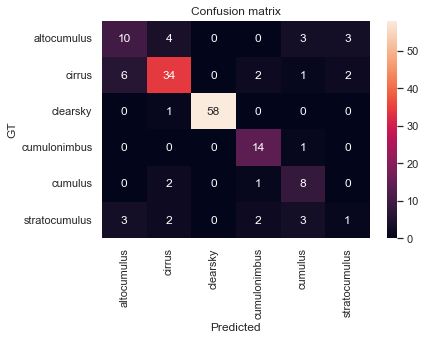

**Running Reg Log Softmax in the test set**

- Accuracy = 0.7888
               precision    recall  f1-score   support

  altocumulus       0.52      0.60      0.56        20
       cirrus       0.81      0.78      0.80        45
     clearsky       1.00      0.97      0.98        59
 cumulonimbus       0.74      0.93      0.82        15
      cumulus       0.53      0.73      0.62        11
stratocumulus       0.25      0.09      0.13        11

     accuracy                           0.79       161
    macro avg       0.64      0.68      0.65       161
 weighted avg       0.78      0.79      0.78       161

Confusion matrix using Pandas and Seaborn:


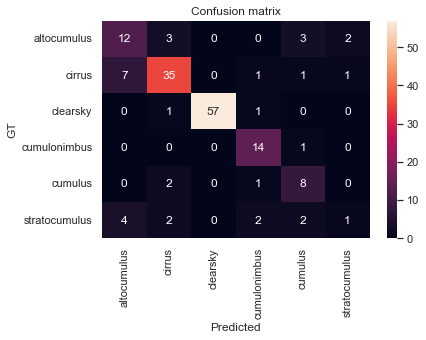

**Running RF in the test set**

- Accuracy = 0.8696
               precision    recall  f1-score   support

  altocumulus       0.67      0.70      0.68        20
       cirrus       0.87      0.89      0.88        45
     clearsky       0.98      0.98      0.98        59
 cumulonimbus       0.94      1.00      0.97        15
      cumulus       0.64      0.82      0.72        11
stratocumulus       0.80      0.36      0.50        11

     accuracy                           0.87       161
    macro avg       0.82      0.79      0.79       161
 weighted avg       0.87      0.87      0.86       161

Confusion matrix using Pandas and Seaborn:


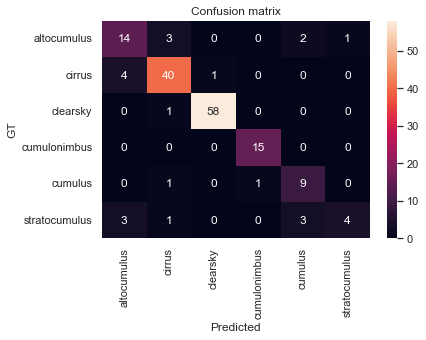

**Running XGBoost in the test set**

- Accuracy = 0.8820
               precision    recall  f1-score   support

  altocumulus       0.67      0.70      0.68        20
       cirrus       0.89      0.87      0.88        45
     clearsky       1.00      0.98      0.99        59
 cumulonimbus       0.94      1.00      0.97        15
      cumulus       0.75      0.82      0.78        11
stratocumulus       0.70      0.64      0.67        11

     accuracy                           0.88       161
    macro avg       0.82      0.83      0.83       161
 weighted avg       0.88      0.88      0.88       161

Confusion matrix using Pandas and Seaborn:


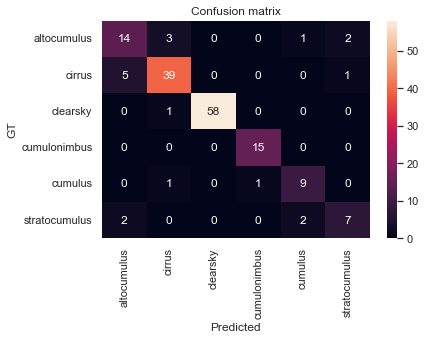

In [33]:
# inicializamos una lista en la que vamos a ir guardando los resultados
results_in_test_set = []
# inicializamos un arreglo donde guardamos los valores de accuracy
accuracies = np.zeros(len(model_names))
# inicializamos un arreglo donde guardamos los valores de índice kappa
kappa = np.zeros(len(model_names))
# inicializamos un arreglo donde guardamos los valores de f1
f1s = [range(6) for i in range(4)]
# inicializamos un arreglo donde guardamos los valores de precision
precisions = [range(6) for i in range(4)]
# inicializamos un arreglo donde guardamos los valores de recall
recalls = [range(6) for i in range(4)]

# iteramos por cada uno de los modelos
i=0
for current_model in models_to_evaluate:
    if i == 3:
        printmd('**Running {} in the test set**'.format(model_names[i]))
        le = LabelEncoder()
        le.fit_transform(np.ravel(y_test))
        y_hat_test = model4.predict(x_test)
        # las agregamos a la lista de resultados
        results_in_test_set.append(y_hat_test)
        # calculamos el accuracy y lo guardamos en el arreglo
        accuracies[i] = accuracy_score(y_test['clasificacion'], le.inverse_transform(y_hat_test))
        kappa[i] = cohen_kappa_score(y_test['clasificacion'], le.inverse_transform(y_hat_test))
        f1s[i] = f1_score(le.fit_transform(np.ravel(y_test)), y_hat_test, average=None)
        precisions[i] = precision_score(le.fit_transform(np.ravel(y_test)), y_hat_test, average=None)
        recalls[i] = recall_score(le.fit_transform(np.ravel(y_test)), y_hat_test, average=None)
        print('- Accuracy = {:.4f}'.format(accuracies[i]))
        print(classification_report(le.fit_transform(np.ravel(y_test)), y_hat_test,target_names=le.classes_))
        # obtenemos la matriz usando pandas y seaborn
        print('Confusion matrix using Pandas and Seaborn:')
        df = pd.DataFrame({'GT': np.ravel(y_test), 'Predicted': le.inverse_transform(y_hat_test)}, columns=['GT','Predicted'])
        conf_mat = pd.crosstab(df['GT'], df['Predicted'], rownames=['GT'], colnames=['Predicted'], margins = False)
        ax = plt.axes()
        sns.heatmap(conf_mat, ax=ax, annot=True)
        ax.set_title('Confusion matrix')
        plt.show()
        
    else:
        printmd('**Running {} in the test set**'.format(model_names[i]))
        # hacemos predicciones sobre los datos de test
        y_hat_test = current_model.predict(x_test)
        # las agregamos a la lista de resultados
        results_in_test_set.append(y_hat_test)
        # calculamos el accuracy y lo guardamos en el arreglo
        accuracies[i] = accuracy_score(y_test, y_hat_test)
        kappa[i] = cohen_kappa_score(y_test, y_hat_test)
        f1s[i] = f1_score(y_test, y_hat_test, average=None)
        precisions[i] = precision_score(y_test, y_hat_test, average=None)
        recalls[i] = recall_score(y_test, y_hat_test, average=None)
        print('- Accuracy = {:.4f}'.format(accuracies[i]))
        # calculamos un reporte
        print(classification_report(y_test, y_hat_test))
        
        # obtenemos la matriz usando pandas y seaborn
        print('Confusion matrix using Pandas and Seaborn:')
              
        df = pd.DataFrame({'GT': np.ravel(y_test), 'Predicted': y_hat_test}, columns=['GT','Predicted'])
        conf_mat = pd.crosstab(np.ravel(y_test), y_hat_test, rownames=['GT'], colnames=['Predicted'], margins = False)
        ax = plt.axes()
        sns.heatmap(conf_mat, ax=ax, annot=True)
        ax.set_title('Confusion matrix')
        plt.show()
        
        i=i+1

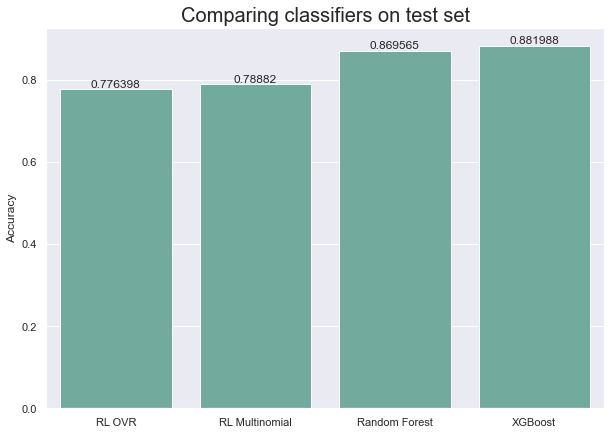

In [34]:
# Accuracy

datos0 = np.array([accuracies[0], accuracies[1], accuracies[2], accuracies[3]])
columnas = ['Accuracy']
filas = ['RL OVR','RL Multinomial','Random Forest','XGBoost']
df = pd.DataFrame(datos0, columns=columnas, index=filas)

# set plot style: grey grid in the background:
sns.set(style="darkgrid")

# Set the figure size
plt.figure(figsize=(10, 7))
plt.title('Comparing classifiers on test set', size='20')

# plot a bar chart
ax = sns.barplot(x=df.index,y=df.Accuracy,data=df,estimator=sum,ci=None,color='#69b3a2')

for i in ax.containers:
    ax.bar_label(i)

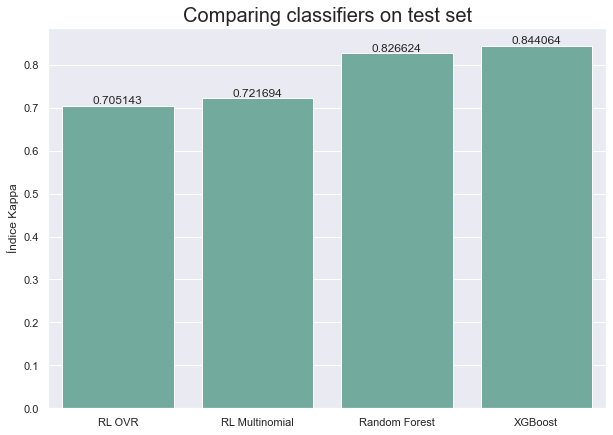

In [35]:
# Índice Kappa

datosk = np.array([kappa[0], kappa[1], kappa[2], kappa[3]])
columnas = ['Índice Kappa']
filas = ['RL OVR','RL Multinomial','Random Forest','XGBoost']
df = pd.DataFrame(datosk, columns=columnas, index=filas)

# set plot style: grey grid in the background:
sns.set(style="darkgrid")

# Set the figure size
plt.figure(figsize=(10, 7))
plt.title('Comparing classifiers on test set', size='20')

# plot a bar chart
ax = sns.barplot(x=df.index,y=df['Índice Kappa'],data=df,estimator=sum,ci=None,color='#69b3a2')

for i in ax.containers:
    ax.bar_label(i)

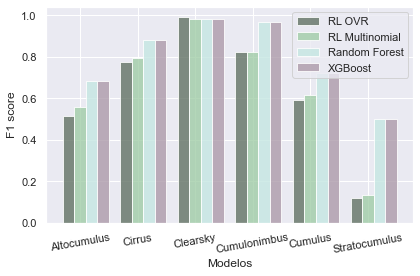

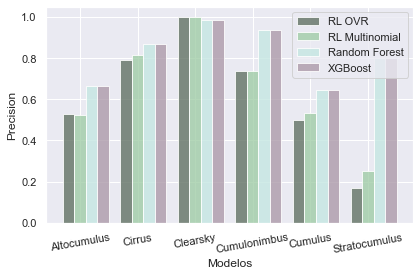

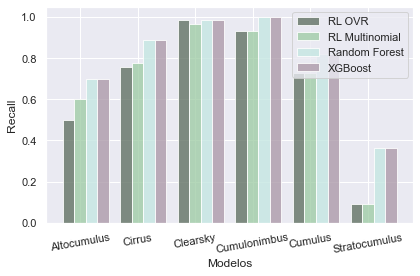

In [36]:
# f1

dataf1 = [f1s[0], f1s[1], f1s[2], f1s[3]]

n_groups = 6 

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

rects1 = plt.bar(index, dataf1[0], bar_width,alpha=opacity,color='#627264',label='RL OVR')
rects2 = plt.bar(index + bar_width, dataf1[1], bar_width,alpha=opacity,color='#A1CDA8',label='RL Multinomial')
rects3 = plt.bar(index + 2*bar_width, dataf1[2], bar_width,alpha=opacity,color='#C5E7E2',label='Random Forest')
rects4 = plt.bar(index + 3*bar_width, dataf1[2], bar_width,alpha=opacity,color='#AD9BAA',label='XGBoost')

plt.xlabel('Modelos')
plt.ylabel('F1 score')
plt.xticks(index + bar_width, ('Altocumulus','Cirrus','Clearsky','Cumulonimbus', 'Cumulus', 'Stratocumulus'),rotation=10)
plt.legend()

plt.tight_layout()
plt.show()

#####

# precision

datap = [precisions[0], precisions[1], precisions[2], precisions[3]]

n_groups = 6 

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

rects1 = plt.bar(index, datap[0], bar_width,alpha=opacity,color='#627264',label='RL OVR')
rects2 = plt.bar(index + bar_width, datap[1], bar_width,alpha=opacity,color='#A1CDA8',label='RL Multinomial')
rects3 = plt.bar(index + 2*bar_width, datap[2], bar_width,alpha=opacity,color='#C5E7E2',label='Random Forest')
rects4 = plt.bar(index + 3*bar_width, datap[2], bar_width,alpha=opacity,color='#AD9BAA',label='XGBoost')

plt.xlabel('Modelos')
plt.ylabel('Precision')
plt.xticks(index + bar_width, ('Altocumulus','Cirrus','Clearsky','Cumulonimbus', 'Cumulus', 'Stratocumulus'),rotation=10)
plt.legend()

plt.tight_layout()
plt.show()

#####

# recall

datar = [recalls[0], recalls[1], recalls[2], recalls[3]]

n_groups = 6 

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

rects1 = plt.bar(index, datar[0], bar_width,alpha=opacity,color='#627264',label='RL OVR')
rects2 = plt.bar(index + bar_width, datar[1], bar_width,alpha=opacity,color='#A1CDA8',label='RL Multinomial')
rects3 = plt.bar(index + 2*bar_width, datar[2], bar_width,alpha=opacity,color='#C5E7E2',label='Random Forest')
rects4 = plt.bar(index + 3*bar_width, datar[2], bar_width,alpha=opacity,color='#AD9BAA',label='XGBoost')

plt.xlabel('Modelos')
plt.ylabel('Recall')
plt.xticks(index + bar_width, ('Altocumulus','Cirrus','Clearsky','Cumulonimbus', 'Cumulus', 'Stratocumulus'),rotation=10)
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\LABORA~1\AppData\Local\Temp/ipykernel_13264/710103499.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]


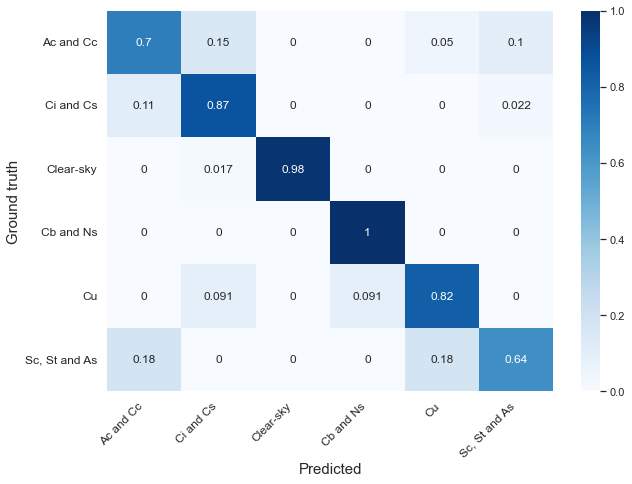

In [37]:
y_hat_test = model4.predict(x_test)
results_in_test_set.append(y_hat_test)

df = pd.DataFrame({'GT': np.ravel(y_test), 'Predicted': y_hat_test}, columns=['GT','Predicted'])
conf_mat = pd.crosstab(np.ravel(y_test), y_hat_test, rownames=['GT'], colnames=['Predicted'], margins = False)

plt.figure(figsize=(10, 7))
cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
ax = plt.axes()
sns.heatmap(cmn, ax=ax, annot=True, cmap='Blues')

# Set font size for axis labels
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground truth", fontsize=15)

# Set font size for tick labels
ax.set_xticklabels(['Ac and Cc', 'Ci and Cs', 'Clear-sky', 'Cb and Ns', 'Cu', 'Sc, St and As'], rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(['Ac and Cc', 'Ci and Cs', 'Clear-sky', 'Cb and Ns', 'Cu', 'Sc, St and As'], rotation=0, fontsize=12)

plt.show()

In [38]:
model4

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='multi:softmax', predictor='auto', ...)

[0.1297454  0.15530251 0.08698185 0.04692888 0.0604222  0.07715599
 0.27048388 0.1729793 ]
[3 4 5 2 0 1 7 6]
[0.04692888 0.0604222  0.07715599 0.08698185 0.1297454  0.15530251
 0.1729793  0.27048388]
['Kurtosis(kt*)', 'Skewness(kt*)', 'Normalized line length', 'Max(kt*)', 'Mean(kt*)', 'Std(kt*)', 'Average variability', 'RMSE']


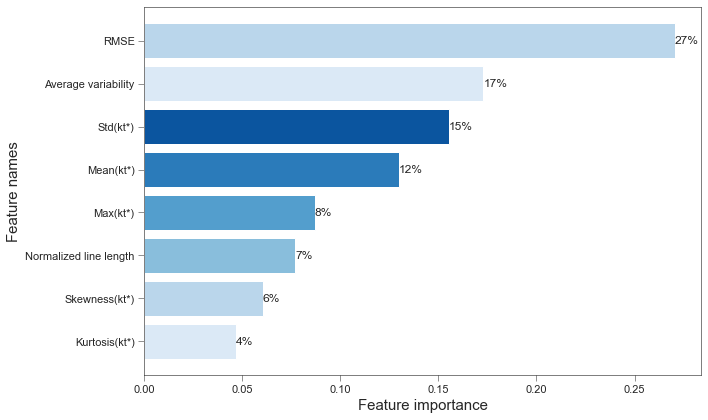

In [39]:
import seaborn as sns

# Obtén la importancia de las características del modelo XGBoost
feature_importance = model4.feature_importances_

print(feature_importance)

# Obtén los nombres de las características
feature_names = ['Mean(kt*)','Std(kt*)',  'Max(kt*)', 'Kurtosis(kt*)', 'Skewness(kt*)','Normalized line length', 'RMSE', 'Average variability']
# Ordena las características por importancia ascendente
sorted_indices = np.argsort(feature_importance)
print(sorted_indices)
sorted_importance = feature_importance[sorted_indices]
print(sorted_importance)
sorted_names = [feature_names[i] for i in sorted_indices]
print(sorted_names)
# Ajusta el ancho de las barras
bar_width = 0.001
# Crea un gráfico de barras horizontales para visualizar la importancia de las características
plt.figure(figsize=(10, 6), facecolor='white')

# Define el estilo de color
color = sns.color_palette('Blues')

bars = plt.barh(range(len(sorted_importance)), sorted_importance, align='center', color=color)

# Agrega el valor de porcentaje al final de cada barra
for bar in bars:
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height() / 2, f'{int(xval*100)}%', ha='left', va='center', fontsize=12)

plt.yticks(range(len(sorted_importance)), sorted_names)
plt.xlabel('Feature importance', fontsize=15)
plt.ylabel('Feature names', fontsize=15)
plt.tight_layout()
plt.grid()
plt.gca().set_facecolor('white')
# Agrega un recuadro negro alrededor de los ejes
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

# Ajusta el grosor de la barrita del eje
plt.tick_params(axis='both', width=0.5)
    
# Muestra las líneas de cada valor del eje x e y
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')

plt.show()

In [40]:
feature_importance = model4.feature_importances_
feature_importance

array([0.1297454 , 0.15530251, 0.08698185, 0.04692888, 0.0604222 ,
       0.07715599, 0.27048388, 0.1729793 ], dtype=float32)

In [41]:
# Importamos los datos de interés, ahora como df
# x train, y train
y_train = pd.DataFrame(y_train)

# create instance of label encoder
le = LabelEncoder()
# perform label encoding on 'team' column
y_train['le'] = le.fit_transform(np.ravel(y_train))
# clases
clases = le.classes_

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['int', 'str']

In [42]:
y_hat_test = model4.predict(x_test)
y_hat_test

array([2, 2, 0, 0, 5, 5, 5, 0, 1, 2, 4, 1, 1, 0, 4, 1, 2, 2, 2, 2, 4, 3,
       1, 5, 2, 0, 4, 0, 3, 2, 4, 2, 1, 2, 1, 5, 1, 4, 3, 1, 2, 2, 2, 1,
       1, 4, 1, 2, 1, 1, 2, 1, 0, 2, 0, 0, 5, 2, 2, 2, 1, 1, 4, 2, 1, 2,
       2, 3, 3, 2, 1, 2, 1, 1, 1, 2, 2, 3, 4, 1, 1, 0, 4, 2, 2, 0, 0, 2,
       2, 2, 4, 2, 2, 0, 2, 2, 1, 3, 1, 2, 2, 2, 3, 3, 3, 3, 1, 2, 2, 1,
       1, 1, 5, 2, 2, 0, 2, 5, 3, 2, 2, 2, 0, 5, 1, 1, 1, 3, 1, 2, 0, 1,
       2, 2, 2, 2, 0, 5, 0, 2, 2, 1, 1, 2, 1, 1, 3, 2, 2, 1, 0, 1, 2, 0,
       4, 1, 3, 1, 3, 1, 0])

In [43]:
model4.feature_importances_

array([0.1297454 , 0.15530251, 0.08698185, 0.04692888, 0.0604222 ,
       0.07715599, 0.27048388, 0.1729793 ], dtype=float32)

In [44]:
#FEATURE ABLATION

In [45]:
y_hat_test = model4.predict(x_test)
y_test2 = le.fit_transform(np.ravel(y_test))

baseline_accuracy = accuracy_score(np.ravel(y_test2), y_hat_test)
baseline_kappa = cohen_kappa_score(np.ravel(y_test2), y_hat_test)
feature_importance = model4.feature_importances_

sorted_indices = np.argsort(feature_importance)[::-1]
print(sorted_indices)

x_test2 = np.array(x_test)
x_train2 = np.array(x_train)

for i in sorted_indices:
    model_ablated = model4
    x_train_ablated = np.delete(x_train2, i, axis=1)
    x_test_ablated = np.delete(x_test2, i, axis=1)
    
    model_ablated.fit(x_train_ablated, y_train['le'])
    # hacemos predicciones sobre los datos de test
    y_hat_test2 = model_ablated.predict(x_test_ablated)
          
    ablated_accuracy = accuracy_score(np.ravel(y_test2), (y_hat_test2))
    ablated_kappa = cohen_kappa_score(np.ravel(y_test2), (y_hat_test2))

    # Calcula la diferencia en la exactitud
    accuracy_difference = baseline_accuracy - ablated_accuracy
    kappa_difference = baseline_kappa - ablated_kappa
    print(classification_report(np.ravel(y_test2), y_hat_test2))
    
    # Imprime los resultados
    print(f"Feature {i} Ablation - Accuracy: {ablated_accuracy}, Accuracy Difference: {accuracy_difference}, Kappa: {ablated_kappa}, Kappa Difference: {kappa_difference}")


[6 7 1 0 2 5 4 3]
              precision    recall  f1-score   support

           0       0.59      0.65      0.62        20
           1       0.86      0.84      0.85        45
           2       1.00      0.98      0.99        59
           3       0.94      1.00      0.97        15
           4       0.73      0.73      0.73        11
           5       0.70      0.64      0.67        11

    accuracy                           0.86       161
   macro avg       0.80      0.81      0.80       161
weighted avg       0.87      0.86      0.86       161

Feature 6 Ablation - Accuracy: 0.8633540372670807, Accuracy Difference: 0.018633540372670843, Kappa: 0.819359445124439, Kappa Difference: 0.024704377070595918
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        20
           1       0.83      0.78      0.80        45
           2       0.98      0.98      0.98        59
           3       0.94      1.00      0.97        15
         

A continuación se realizó un análisis de bootstrap junto con el feature ablation. Como en el código anterior las diferencias son muy bajas, usamos la técnica de bootstrap para generar N conjuntos de test no disjuntos entre sí, de un tamaño aproximado al 80% del dataset original. Luego, para cada uno de los resultados de los modelos ablacionados se hizo un test de hipótesis para evaluar si esas diferencias son significativas respecto al modelo final:

In [46]:
n_bootstrap_iterations = 500

columns = [f'feature_{i}' for i in sorted_indices]
acc_res = pd.DataFrame(columns=columns)
kappa_res = pd.DataFrame(columns=columns)
baseline_acc = []
baseline_kapp = []

for _ in range(n_bootstrap_iterations):
    sample_indices = sample_indices = np.random.choice(len(x_test), size = 128, replace=True) # Le puse 128 xq es un 80% aprox del Dataset original
    x_test_bootstrap = x_test2[sample_indices]
    y_test_bootstrap = y_test2[sample_indices]
    
    model4.fit(x_train2, y_train['le'])  
    y_hat_test_baseline = model4.predict(x_test_bootstrap)
    
    baseline_accuracy = accuracy_score(np.ravel(y_test_bootstrap), y_hat_test_baseline)
    baseline_acc.append(baseline_accuracy)
    
    baseline_kappa = cohen_kappa_score(np.ravel(y_test_bootstrap), y_hat_test_baseline)
    baseline_kapp.append(baseline_kappa)
    
    abliteration_results_acc = [] 
    abliteration_results_kappa = [] 
    
    for i in sorted_indices:
        model_ablated = model4
        x_train_ablated = np.delete(x_train2, i, axis=1)
        x_test_ablated = np.delete(x_test_bootstrap, i, axis=1)
        
        model_ablated.fit(x_train_ablated, y_train['le'])
        # Hacer predicciones sobre los datos de prueba
        y_hat_test2 = model_ablated.predict(x_test_ablated)
        
        ablated_accuracy = accuracy_score(np.ravel(y_test_bootstrap), y_hat_test2)
                
        ablated_kappa = cohen_kappa_score(np.ravel(y_test_bootstrap), (y_hat_test2))
                
        abliteration_results_acc.append(ablated_accuracy)
        abliteration_results_kappa.append(ablated_kappa)
    
    acc_res.loc[len(acc_res)] = abliteration_results_acc 
    kappa_res.loc[len(kappa_res)] = abliteration_results_kappa

KeyboardInterrupt: 

In [104]:
acc_res

,feature_6,feature_7,feature_1,feature_0,feature_2,feature_5,feature_4,feature_3
0,0.875000,0.828125,0.898438,0.867188,0.867188,0.890625,0.875000,0.875000
1,0.867188,0.851562,0.867188,0.875000,0.882812,0.898438,0.898438,0.914062
2,0.890625,0.828125,0.867188,0.890625,0.851562,0.914062,0.875000,0.882812
3,0.875000,0.890625,0.890625,0.882812,0.867188,0.906250,0.882812,0.921875
4,0.890625,0.890625,0.898438,0.906250,0.890625,0.906250,0.898438,0.914062
...,...,...,...,...,...,...,...,...
495,0.851562,0.851562,0.859375,0.882812,0.859375,0.882812,0.875000,0.914062
496,0.867188,0.843750,0.914062,0.882812,0.882812,0.875000,0.890625,0.898438
497,0.882812,0.835938,0.882812,0.875000,0.898438,0.890625,0.882812,0.875000
498,0.843750,0.843750,0.859375,0.835938,0.851562,0.898438,0.867188,0.898438


In [173]:
acc_res.to_csv('acc_res.csv', index=False)

In [105]:
baseline_acc

[0.875,
 0.8984375,
 0.8828125,
 0.8984375,
 0.90625,
 0.9296875,
 0.8671875,
 0.9296875,
 0.859375,
 0.8984375,
 0.8515625,
 0.890625,
 0.8984375,
 0.8984375,
 0.859375,
 0.9140625,
 0.8671875,
 0.9140625,
 0.8359375,
 0.90625,
 0.859375,
 0.8203125,
 0.9140625,
 0.875,
 0.8359375,
 0.9453125,
 0.8984375,
 0.90625,
 0.890625,
 0.9140625,
 0.8125,
 0.8671875,
 0.8359375,
 0.890625,
 0.890625,
 0.921875,
 0.875,
 0.9296875,
 0.875,
 0.8984375,
 0.8828125,
 0.859375,
 0.828125,
 0.90625,
 0.9140625,
 0.8671875,
 0.8671875,
 0.875,
 0.875,
 0.890625,
 0.890625,
 0.9140625,
 0.875,
 0.8828125,
 0.921875,
 0.8515625,
 0.8828125,
 0.8671875,
 0.953125,
 0.875,
 0.8984375,
 0.859375,
 0.875,
 0.9140625,
 0.8515625,
 0.8984375,
 0.8828125,
 0.8828125,
 0.8828125,
 0.90625,
 0.90625,
 0.8515625,
 0.828125,
 0.9375,
 0.859375,
 0.8828125,
 0.8828125,
 0.890625,
 0.8984375,
 0.8515625,
 0.875,
 0.890625,
 0.921875,
 0.8671875,
 0.890625,
 0.8984375,
 0.875,
 0.859375,
 0.890625,
 0.8671875,
 0.88

In [175]:
pd.DataFrame(baseline_acc).to_csv('baseline_acc.csv', index=False)

In [106]:
kappa_res

,feature_6,feature_7,feature_1,feature_0,feature_2,feature_5,feature_4,feature_3
0,0.834385,0.772187,0.865437,0.824091,0.823806,0.854722,0.834385,0.834264
1,0.829747,0.809225,0.829920,0.838892,0.849730,0.869172,0.869213,0.889421
2,0.860436,0.782026,0.830252,0.860022,0.810074,0.889957,0.840324,0.850362
3,0.836304,0.855972,0.856284,0.844899,0.827123,0.876656,0.844597,0.896154
4,0.853355,0.853103,0.863248,0.874057,0.852813,0.873549,0.863248,0.883886
...,...,...,...,...,...,...,...,...
495,0.800345,0.799736,0.811580,0.841440,0.810962,0.841270,0.831634,0.882510
496,0.823219,0.791650,0.884600,0.843712,0.843086,0.833333,0.853881,0.864185
497,0.849754,0.791045,0.850560,0.839837,0.869837,0.859847,0.849365,0.840212
498,0.783491,0.782202,0.804281,0.768754,0.793513,0.857192,0.814239,0.856378


In [177]:
kappa_res.to_csv('kappa_res.csv', index=False)

In [107]:
baseline_kapp

[0.8347987416310397,
 0.8696435566000783,
 0.8506882339217668,
 0.865946991057762,
 0.8738709147643291,
 0.90625,
 0.8221059516023544,
 0.90289134283065,
 0.8051915109495222,
 0.863191646797665,
 0.8036175710594315,
 0.857766489403921,
 0.8700609089489302,
 0.8616446329092875,
 0.8158420589880905,
 0.8899398108340498,
 0.8261980830670926,
 0.8893864404116584,
 0.780714635340186,
 0.8759088705768299,
 0.8153698212997836,
 0.7654370169707593,
 0.8865156766341581,
 0.8389683912564869,
 0.7922559703222815,
 0.9249266862170088,
 0.8586956521739131,
 0.8689978678038379,
 0.8540241120886283,
 0.8836267460120671,
 0.7496740547588006,
 0.8278208577306536,
 0.7825418655448588,
 0.8598576679440056,
 0.8471772130308716,
 0.8953821005312628,
 0.8391454602576186,
 0.9097390895557471,
 0.8367997449996015,
 0.8600739993272788,
 0.8426616405801852,
 0.8084469571000997,
 0.7798968266374864,
 0.8720639680159921,
 0.8850049003593596,
 0.8217124129455141,
 0.8230462714483208,
 0.8360156938105533,
 0.838816

In [176]:
pd.DataFrame(baseline_kapp).to_csv('baseline_kapp.csv', index=False)

In [108]:
np.mean(acc_res.feature_7) - np.mean(baseline_acc)

-0.048531250000000026

In [111]:
from scipy.stats import ttest_ind

# Realizar el test t de Student
t_statistic, p_value = ttest_ind(acc_res.feature_7, baseline_acc)

print(f"P-valor del test t de Student: {p_value}")



P-valor del test t de Student: 1.6573208303787326e-109


In [112]:
from scipy.stats import wilcoxon

wilcoxon_results = []

for column_name, column_data in acc_res.items():
    statistic, p_value = wilcoxon(column_data, baseline_acc)
    
    wilcoxon_results.append({
        "Feature": column_name,
        "Statistic": statistic,
        "P-Value": p_value,
        "Significant": p_value < 0.05
    })

wilcoxon_df = pd.DataFrame(wilcoxon_results)
print(wilcoxon_df)

     Feature  Statistic       P-Value  Significant
0  feature_6     7759.5  6.521324e-55         True
1  feature_7        0.0  3.002920e-83         True
2  feature_1    26129.5  2.615613e-11         True
3  feature_0    14308.5  2.359372e-35         True
4  feature_2     9837.5  1.456867e-48         True
5  feature_5    30385.5  2.002724e-10         True
6  feature_4    24043.5  1.966765e-17         True
7  feature_3    19069.0  3.987969e-19         True


In [164]:
print(sorted_names[::-1])

['RMSE', 'Average variability', 'Std(kt*)', 'Mean(kt*)', 'Max(kt*)', 'Normalized line length', 'Skewness(kt*)', 'Kurtosis(kt*)']


In [171]:
from scipy.stats import wilcoxon

wilcoxon_results = []

for column_name, column_data in kappa_res.items():
    statistic, p_value = wilcoxon(column_data, baseline_kapp)
    
    wilcoxon_results.append({
        "Feature": column_name,
        "Statistic": statistic,
        "P-Value": p_value,
        "Significant": p_value < 0.05
    })

wilcoxon_df = pd.DataFrame(wilcoxon_results)
print(wilcoxon_df)

     Feature  Statistic       P-Value  Significant
0  feature_6    10332.0  1.151195e-58         True
1  feature_7        0.0  1.264719e-83         True
2  feature_1    37868.0  4.357125e-14         True
3  feature_0    17849.0  2.023976e-43         True
4  feature_2    13058.0  4.478356e-53         True
5  feature_5    47412.0  3.432514e-06         True
6  feature_4    27502.0  1.369451e-25         True
7  feature_3    38802.0  3.276045e-11         True


In [172]:
new_feature_names = sorted_names[::-1]

for i, new_name in enumerate(new_feature_names):
    wilcoxon_df.at[i, 'Feature'] = new_name

print(wilcoxon_df)

                  Feature  Statistic       P-Value  Significant
0                    RMSE    10332.0  1.151195e-58         True
1     Average variability        0.0  1.264719e-83         True
2                Std(kt*)    37868.0  4.357125e-14         True
3               Mean(kt*)    17849.0  2.023976e-43         True
4                Max(kt*)    13058.0  4.478356e-53         True
5  Normalized line length    47412.0  3.432514e-06         True
6           Skewness(kt*)    27502.0  1.369451e-25         True
7           Kurtosis(kt*)    38802.0  3.276045e-11         True


# Análisis de casos con más de una nube

In [194]:
# x test extra mixed
x_test_mixed_ = pd.read_csv('dias_test_filtrado_mixed_33min_3.csv')
x_test_mixed = x_test_mixed_[name]
x_test_mixed = x_test_mixed.dropna()
x_test_mixed_cc = pd.read_csv('dias_test_filtrado_mixed_33min_3.csv')
y_test_mixed = pd.DataFrame(x_test_mixed_.clasificacion)
x_test_mixed

,kt_modificado_mean,kt_modificado_std,kt_modificado_max,kurt_kt_modificado,skew_kt_modificado,long_std,rmse,sigma_mean
0,0.567234,0.294851,0.989173,-1.827937,0.057322,46.214759,408.490186,0.076633
1,0.490458,0.081491,0.593989,-1.475450,-0.277329,8.744639,307.329317,0.023217
2,0.841084,0.185630,1.149045,-1.020441,-0.247759,37.239699,211.622557,0.140736
3,0.606779,0.227122,0.888419,-1.280342,-0.531359,75.254464,365.293481,0.117472
4,0.592285,0.128524,0.854108,0.137360,-0.200315,6.723953,78.074814,0.035839
5,0.790796,0.091674,0.878591,3.661014,-2.062531,71.522862,118.678225,0.102936
6,0.657473,0.149186,0.882558,-0.816010,-0.492683,17.742656,91.879505,0.203576
7,0.742800,0.050793,0.822879,2.942463,-1.691676,30.202208,62.609316,0.045443
9,0.746792,0.166818,0.900577,1.816954,-1.739671,283.454207,201.107121,0.119320
10,0.764215,0.180796,0.955483,0.638701,-1.026580,55.108086,176.301090,0.124175


In [158]:
mu

kt_modificado_mean      0.670167
kt_modificado_std       0.115648
kt_modificado_max       0.842688
kurt_kt_modificado      0.248645
skew_kt_modificado     -0.294164
long_std              457.116486
rmse                  167.488495
sigma_mean              0.071786
dtype: float64

In [159]:
sigma

kt_modificado_mean       0.191608
kt_modificado_std        0.098996
kt_modificado_max        0.203656
kurt_kt_modificado       3.018106
skew_kt_modificado       1.021233
long_std              6284.186887
rmse                   169.403111
sigma_mean               0.071772
dtype: float64

In [195]:
# Normalizamos los datos para evitar data leakage
x_test_mixed = (x_test_mixed - mu) / sigma

In [196]:
x_test_mixed

,kt_modificado_mean,kt_modificado_std,kt_modificado_max,kurt_kt_modificado,skew_kt_modificado,long_std,rmse,sigma_mean
0,-0.537207,1.810204,0.719279,-0.688041,0.344178,-0.065387,1.422652,0.067527
1,-0.937897,-0.345028,-1.221172,-0.571251,0.016485,-0.071349,0.825491,-0.676721
2,0.892015,0.706922,1.504287,-0.420491,0.045440,-0.066815,0.260527,0.960675
3,-0.330819,1.126053,0.224550,-0.506605,-0.232264,-0.060766,1.167659,0.636545
4,-0.406466,0.130068,0.056075,-0.036872,0.091898,-0.071671,-0.527816,-0.500857
5,0.629563,-0.242163,0.176294,1.130633,-1.731600,-0.061359,-0.288131,0.434017
6,-0.066250,0.338784,0.195771,-0.352756,-0.194392,-0.069917,-0.446326,1.836240
7,0.379070,-0.655125,-0.097265,0.892552,-1.368456,-0.067935,-0.619110,-0.367046
9,0.399904,0.516891,0.284250,0.519633,-1.415453,-0.027635,0.198453,0.662289
10,0.490835,0.658096,0.553852,0.129239,-0.717188,-0.063971,0.052021,0.729929


In [197]:
from scipy.stats import entropy

# XGBoost
y_hat_test = model4.predict(x_test)
results_in_test_set.append(y_hat_test)

# probabilidades
probs = model4.predict_proba(x_test) 

probs_adjusted = probs

entropies = -np.sum(probs_adjusted * np.log2(probs_adjusted),axis=1)

probs = pd.DataFrame(probs)
probs['H'] = entropies

average_entropies = np.mean(probs.H)
average_entropies

0.39040345

In [198]:
# Calcular la entropía con la funcion
# ent = entropy(probs, base=2, axis=1) # da igual, ojo que probs no tenga H cuando corres esto!
# entr_mean = np.mean(ent) # 0.7653306230604298

# PREDECIMOS NUESTRO MODELO EN EL CONJUNTO DE X_TEST_MIXED

y_hat_test_mixed = model4.predict(x_test_mixed)

# probabilidades
probs_mixed = model4.predict_proba(x_test_mixed)

# Calcular entropías
entropies_mixed = -np.sum(probs_mixed * np.log2(probs_mixed), axis=1)

probs_mixed = pd.DataFrame(probs_mixed)
probs_mixed['H'] = entropies_mixed

average_entropies_mixed = np.mean(probs_mixed['H'])
average_entropies_mixed

1.0135114

In [199]:
probs_mixed

,0,1,2,3,4,5,H
0,0.688034,0.003259,0.000569,0.009002,0.192499,0.106636,1.267332
1,0.959330,0.024504,0.000278,0.000717,0.000532,0.014639,0.294352
2,0.899394,0.054587,0.000200,0.000591,0.009609,0.035620,0.611149
3,0.015994,0.008399,0.000109,0.000527,0.849514,0.125457,0.736113
4,0.251397,0.739452,0.000181,0.000429,0.007536,0.001006,0.892990
5,0.020030,0.228502,0.000509,0.004053,0.093708,0.653198,1.358829
6,0.579742,0.100085,0.000336,0.002826,0.017741,0.299272,1.440198
7,0.335932,0.649089,0.000889,0.002166,0.010789,0.001135,1.043179
8,0.023200,0.110302,0.000127,0.000514,0.384143,0.481715,1.521868
9,0.383827,0.314240,0.000194,0.000269,0.271396,0.030075,1.723305


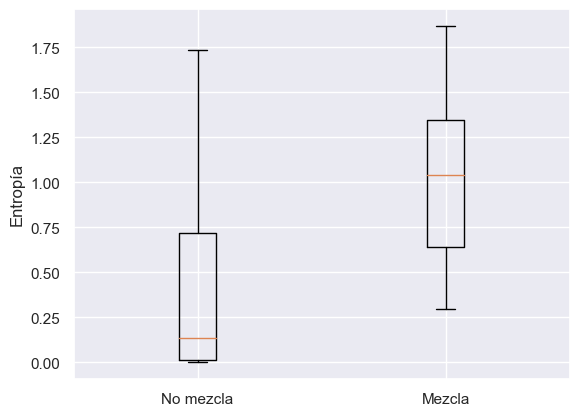

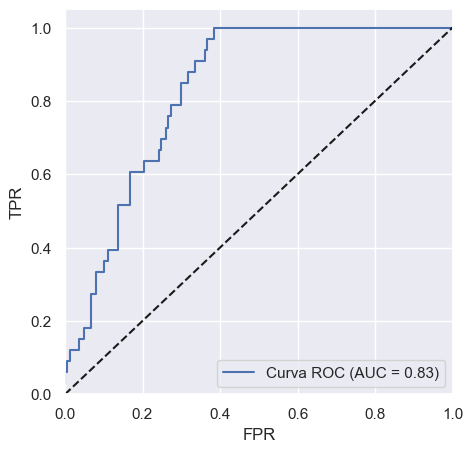

In [200]:
# Boxplot
data = [probs.H, probs_mixed.H]
fig, ax = plt.subplots()
boxplot = ax.boxplot(data)
ax.set_xticklabels(['Not-mixed', 'Mixed'])
ax.set_ylabel('Entropy')
plt.show()

# Curva ROC
from sklearn.metrics import roc_curve, roc_auc_score

# Datos de entropía del dataframe "No mezcla"
scores_no_mezcla = probs['H']
labels_no_mezcla = np.zeros(len(scores_no_mezcla))  # Etiqueta de clase para "No mezcla"

# Datos de entropía del dataframe "Mezcla"
scores_mezcla = probs_mixed['H']
labels_mezcla = np.ones(len(scores_mezcla))  # Etiqueta de clase para "Mezcla"

# Combinar los scores y las etiquetas
scores = np.concatenate((scores_no_mezcla, scores_mezcla))
labels = np.concatenate((labels_no_mezcla, labels_mezcla))

# Calcular tasas de verdaderos positivos y falsos positivos para diferentes umbrales
thresholds = np.unique(scores)
#thresholds = [0,1,2,3]
tpr_values = []
fpr_values = []

for threshold in thresholds:
    predictions = scores >= threshold
    tpr = np.sum(predictions[labels == 1]) / np.sum(labels == 1)
    fpr = np.sum(predictions[labels == 0]) / np.sum(labels == 0)
    tpr_values.append(tpr)
    fpr_values.append(fpr)

# Calcular el área bajo la curva ROC (AUC)
auc = roc_auc_score(labels, scores)

#fpr, tpr, thresholds = roc_curve(labels, scores) # Con este lo calculo con la funcion del paquete de python, da igual!

# Trazar la curva ROC (puntos discretos)
plt.figure(figsize=(5, 5))
plt.plot(fpr_values, tpr_values, label=f'Curva ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.grid(True)
plt.legend()
plt.show()

XGBoost - AUC = 0.8306


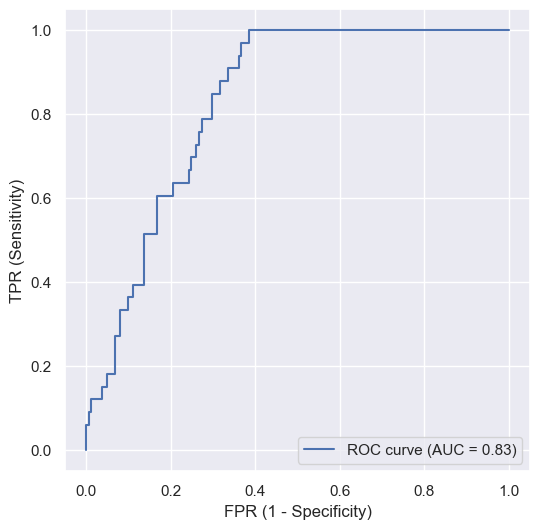

In [202]:
fpr, tpr, thresholds = roc_curve(labels, scores)
auc_values = roc_auc_score(labels, scores)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
print('{} - AUC = {:.4f}'.format('XGBoost', auc_values))
plt.xlabel('FPR (1 - Specificity)')
plt.ylabel('TPR (Sensitivity)')
plt.grid(True)
plt.legend()
plt.show()

fpr, tpr, thresholds = roc_curve(labels, scores)
auc_values = roc_auc_score(labels, scores)
plt.figure(figsize=(6, 6))
plt.style.use('default')
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
print('{} - AUC = {:.4f}'.format('XGBoost', auc_values))
plt.xlabel('FPR (1 - Specificity)', fontsize='16')
plt.ylabel('TPR (Sensitivity)', fontsize='16')
plt.gca().set_facecolor('white')
plt.grid(True)
plt.legend(loc='lower right', fontsize='14')
plt.show()

In [53]:
model_names

['Regularized Log Reg', 'Reg Log Softmax', 'RF', 'XGBoost']

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score

# variable para determinar si queremos hacer zoom o no
#zoom = False
zoom = True

# inicializamos una matriz para los valores de AUC
auc_values = np.zeros(len(model_names))

# recorremos cada uno de los modelos
for i in range(len(model_names)):
  # generamos la curva roc
  fpr, tpr, thresholds = roc_curve(dataset['y_test'], score_based_results_in_test_set[i])
  auc_values[i] = roc_auc_score(dataset['y_test'], score_based_results_in_test_set[i])
  # la mostramos
  plt.plot(fpr, tpr)
  print('{} - AUC = {:.4f}'.format(model_names[i], auc_values[i]))

# si queremos aplicar un zoom
if zoom:
  plt.xlim(0.0, 0.5)
  plt.ylim(0.5, 1.0)  
plt.xlabel('FPR (1 - Specificity)')
plt.ylabel('TPR (Sensitivity)')
plt.title('ROC curves')
plt.grid(True)
plt.legend(model_names, loc='lower right')
plt.show()


NameError: name 'dataset' is not defined